In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
from statsmodels.stats import multitest

from Modules import plot_ax_violin
from Modules import map_to_embeddings
from Modules import generate_figures

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [14]:
def get_data():
    df_ephys, df_seq, df_labels = plot_ax_violin.get_lab_pvalb_dataset()
    df_labels = df_labels.loc[df_labels.Age>20]
    df_ephys = df_ephys.loc[df_ephys.index.isin(df_labels.index)]
    #df_ephys = df_ephys.loc[df_ephys.isna().sum(axis=1)==0]
    df_seq = df_seq.loc[df_seq.index.isin(df_labels.index)]
    columns = [
               'Resting membrane potential (mV)', 'Input resistance (MOhm)', 'Capacitance (pF)',
               'AP firing threshold (pA)', 'AP symmetricity', 'AP peak amplitude (mV)', 
               'AP halfwidth (ms)', 'Frequency Slope (Hz/pA)', 'Attenuation',
               'Sag potential'
              ]
    column_names = [r'V$_{resting}$ (mv)',
                    r'R$_{input}$ (mΩ)',
                    'C (pF)',
                    'AP threshold (pA)',
                    'AP symmetricity',
                    'AP amplitude (mV)',
                    'AP halfwidth (ms)',
                    r'dF/dI$_{step}$ (Hz/pA)',
                    'Attenuation',
                    'Sag (mV)'
                   ]
    df_ephys = df_ephys.loc[:,columns]
    df_ephys.columns = column_names
    
    labels = df_labels.loc[df_ephys.index, 'CellType']
    df_ephys.index = labels
        
    labels = df_labels.loc[df_seq.index, 'CellType']
    df_seq.index = labels
    
    return df_ephys, df_seq

def plot_dataframe(fig, df, top=.9):
    # initialize variables
    celltypes = ('vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC')
    df_marker = pd.read_csv('References/marker_ref.txt', sep='\t', header=0, index_col=0)
    params = {'left':.20,
              'right':.50,
              'row_count':2,
              'rotation':45,
              'ticklabels':celltypes,
              'df_marker':df_marker,
              'show_violin':False,
              'show_error':True,
              'show_box':False,
              'height':.055,
              'dh':.035,
              'ylabel_coords':(-0.225, 0.5),
              'show_signif':True
             }
    
    # generate figure
    args = (fig, top, df.iloc[:,:8], celltypes)
    plot_ax_violin.plot_generated_electrophys(*args, **params)
    params['left'] = .50
    params['right'] = .80
    args = (fig, top, df.iloc[:,8:], celltypes)
    plot_ax_violin.plot_generated_electrophys(*args, **params)
    
    return

def get_label_order(labels, ncol):  
    if 'vAAC' in labels:
        labels = ['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC']
    elif 'AAC' in labels:
        labels = ['AAC', 'BIC', 'BC']
    else:
        labels = sorted(set(labels))
    
    labels = [labels[i+j] for i in range(ncol) for j in range(0,len(labels),ncol) if i+j < len(labels)]
    
    return labels

def plot_embedding(df, labels, title, df_markers, ax, cluster=0, ncol=2):
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(title, fontsize=7, y=.95)
    ax.set_xlabel(r'UMAP$_1$', fontsize=7, labelpad=2)
    ax.set_ylabel(r'UMAP$_2$', fontsize=7, labelpad=1)
    
    if cluster > 1:
            kmeans = KMeans(n_clusters=cluster, random_state=12).fit(df.values)
            labels = pd.Series(['Ephys%d' % label for label in kmeans.labels_ + 1])
    
    for label in get_label_order(labels.values, ncol):
        inds = (labels==label).values
        face, edge, marker = df_markers.loc[label, ['Face', 'Edge', 'Marker']]
        ax.scatter(df.iloc[inds,0], df.iloc[inds,1], facecolor=face,
                   edgecolor=edge,
                   marker=marker,
                   s=16,
                   label=label, linewidth=.5)
    
    kwargs = {'loc':'upper center', 
              'bbox_to_anchor':(0.5,-.13),
              'fontsize':5,
              'ncol':ncol,
              'handletextpad':0,
              'borderaxespad':0.3,
              'borderpad':0.2,
              'markerscale':.5,
              'handlelength':1,
              'columnspacing':1
             }
    ax.legend(**kwargs)
    
    return

def plot_embeddings(fig):
    df_embed = pd.read_csv('Mapping/Embeddings/Lab_Pvalb-ephys.tsv', sep='\t', header=0, index_col=0)
    fname = 'References/marker_ref.txt'
    
    params = {'sep':'\t', 'header':0, 'index_col':0}
    df_markers = pd.read_csv(fname, **params)
    
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    df_labels = pd.read_csv(fname, **kwargs)
    df_labels = df_labels.loc[df_embed.index]
    
    labels = ['MorphDirectional-PV-types',
              'MorphMarker-PV-types',
              'proMMT-PV-types',
              'Morph-PV-types'
             ]
    titles = ['Dendro-morphological types',
              'Axo-morphological types',
              'proMMT types',
              '5 morphological types'
             ]
    ncols = [2,3,1,3]
    
    for num, (label, title, ncol) in enumerate(zip(labels, titles, ncols)):
        row = num // 2
        col = num % 2
        ax = fig.add_axes([.545 + .145*col, .685 - .125*row, .11, .085])
        plot_embedding(df_embed[['UMAP_X', 'UMAP_Y']], df_labels[label], title, df_markers, ax, ncol=ncol)
    
    return

In [15]:
df_ephys, df_seq = get_data()

CPU times: user 2.66 s, sys: 1.02 s, total: 3.68 s
Wall time: 1.66 s


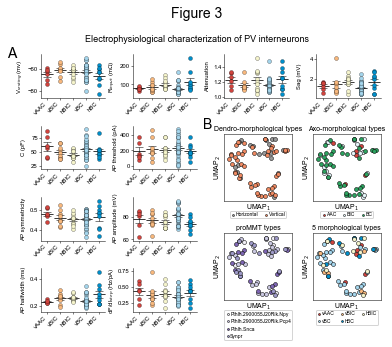

In [16]:
%%time

fig = generate_figures.generate_figure_03()
plot_dataframe(fig, df_ephys, top=.87)
plot_embeddings(fig)
fig.savefig('Figures/Figure 3.pdf')